This notebook is copyright 2024 Jens Scheidtmann. 
It is licensed under a BSD 3-clause license, see file LICENSE in this folder.

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/jscheidtmann/guiding-pynb/HEAD?labpath=PictureStats.ipynb)

# Analyse Meta Data of an imaging session

Assumes that you have a directory "start_dir" on your harddisk, where: 
 * the "Session Metadata" plugin stored info for each subframe
 * you used the SubframeSelector process in PixInsight on the registered frames (including Local Normalization & Drizzle infos) 
 

## Configuration Settings

In [1]:
import sys
!{sys.executable} -m pip install numpy pandas seaborn statsmodels

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd

# This is the directory, down below we look for information files.
#
# Note that we assume, that all files end with .csv!
#
start_dir = "/mnt/d/Bilder/astroupload/2024-01-10" # M81 M82

# How to detect relevant files:
subframeselector_prefix = "SubframeSelector"
nina_acq_details = "AcquisitionDetails.csv"
nina_image_metadata = "ImageMetaData.csv"


## Integration Results

This are values determined by SubframeSelector on the integrated images:

In [3]:
final_Eccentricity = (0.397 + 0.382) / 2.
final_FWHM = (2.812 + 3.003) / 2.

## Find Files

Which files will be read by this notebook?

In [4]:
from pathlib import Path

def IterateAllCSVFiles (dir: str):
    pathlist = Path(dir).glob('**/*.csv')
    for path in pathlist:
        # because path is object not string
        yield path

for p in IterateAllCSVFiles(start_dir):
    print (str(p))

/mnt/d/Bilder/astroupload/2024-01-10/MasterValues_M8182.csv
/mnt/d/Bilder/astroupload/2024-01-10/SubframeSelector_M8182.csv
/mnt/d/Bilder/astroupload/2024-01-10/M 81 M 82/LIGHT/AcquisitionDetails.csv
/mnt/d/Bilder/astroupload/2024-01-10/M 81 M 82/LIGHT/ImageMetaData.csv


## Read Data
Iterate over all CSV files containted in `start_dir` and read in the data. Merge the "Acquisition Details" and "Image Meta Data" of each directory (assuming there's a directory per target, and multiple targets in an imaging night).

Assumes that files are iterated in lexical order, i.e. AcquisitionDetails comes before ImageMetaData.

In [5]:
if 'df_ss' in locals():
    del df_ss
if 'df' in locals():
    del df

df_acq_path = ""
for p in IterateAllCSVFiles(start_dir):
    # print(str(p))
    if p.name.startswith(subframeselector_prefix): 
        if 'df_ss' in locals():
            print("SubframeSelector data found:", p.name)
            df_ss = pd.concat([df_ss, pd.read_csv(p, header=22)])
        else:
            df_ss = pd.read_csv(p, header=22)
    elif p.name == nina_acq_details: 
        # Read acquisition information
        print("Acquisition info found:", p.name)
        df_acq = pd.read_csv(p)
    elif p.name == nina_image_metadata:
        print("Meta data found:", p.name)
        # Read meta information
        df_meta = pd.read_csv(p)
        
        # Assumes that df_acq has been correctly set before (they come in pairs and acq is before metainfo)
        # Merge the two
        if 'df' in locals():
            df = pd.concat([df, df_acq.merge(df_meta, how='cross')])
        else:
            df = df_acq.merge(df_meta, how='cross')


Acquisition info found: AcquisitionDetails.csv
Meta data found: ImageMetaData.csv


Extract filenames from given paths and add them as additional columns:

Assumes that SubframeSelector-files have "_c_d_r" suffix (or similar), and removes 6 characters from the end of the name.

In [6]:
# Now extract filename from "File" attribute
df_ss.insert(3, 'FileName', [str(Path(f).stem)[:-6] for f in df_ss.File])


In [7]:
df.insert(13, 'FileName', [str(Path(f).stem) for f in df.FilePath])

Merge the two dataframes

In [8]:
data = df.merge(df_ss, left_on='FileName', right_on='FileName')


In [9]:
data = data.astype({
    'TargetName': 'category', 
    'TelescopeName': 'category', 
    'CameraName': 'category',
    'FilterName': 'category'
})


In [10]:
data['ExposureStart'] = pd.to_datetime(data['ExposureStart'], format="%m/%d/%Y %H:%M:%S")


In [11]:
data.columns

Index(['TargetName', 'RACoordinates', 'DECCoordinates', 'TelescopeName',
       'FocalLength', 'FocalRatio', 'CameraName', 'PixelSize', 'BitDepth',
       'ObserverLatitude', 'ObserverLongitude', 'ObserverElevation',
       'ExposureNumber', 'FileName', 'FilePath', 'FilterName', 'ExposureStart',
       'Duration', 'Binning', 'CameraTemp', 'CameraTargetTemp', 'Gain',
       'Offset', 'ADUStDev', 'ADUMean', 'ADUMedian', 'ADUMin', 'ADUMax',
       'DetectedStars', 'HFR', 'HFRStDev', 'GuidingRMS', 'GuidingRMSArcSec',
       'GuidingRMSRA', 'GuidingRMSRAArcSec', 'GuidingRMSDEC',
       'GuidingRMSDECArcSec', 'FocuserPosition', 'FocuserTemp',
       'RotatorPosition', 'PierSide', 'Airmass', 'Index', 'Approved', 'Locked',
       'File', 'Weight', 'PSF Signal Weight', 'PSF SNR', 'PSF Scale',
       'PSF Scale SNR', 'PSF Count', 'M*', 'N*', 'SNR', 'FWHM', 'Eccentricity',
       'Altitude', 'Azimuth', 'Median', 'Median Mean Deviation', 'Noise',
       'Noise Ratio', 'Stars', 'Star Residual', 'PS

# Plot some stats

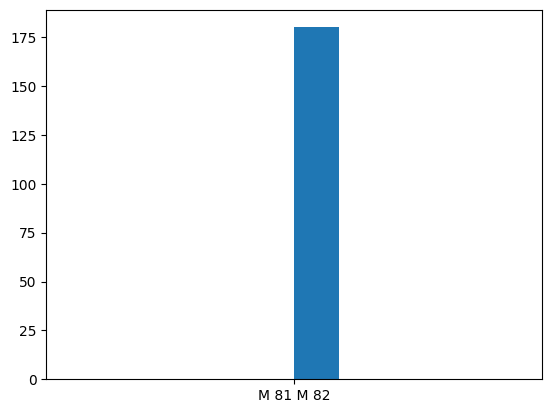

In [12]:
import matplotlib.pyplot as plt

plt.hist(data.TargetName)
plt.show()

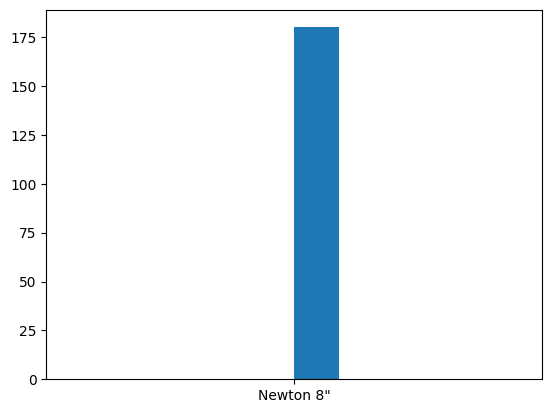

In [13]:
plt.hist(data.TelescopeName)
plt.show()

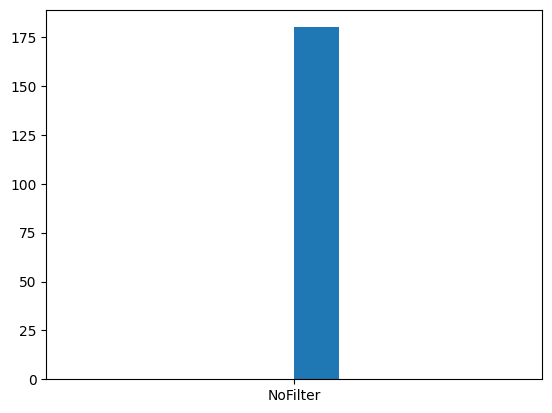

In [14]:
plt.hist(data.FilterName)
plt.show()

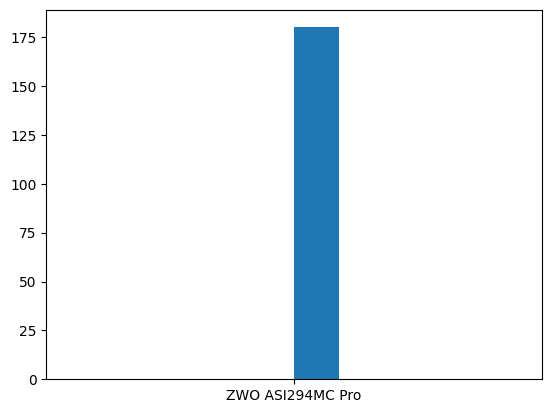

In [15]:
plt.hist(data.CameraName)
plt.show()

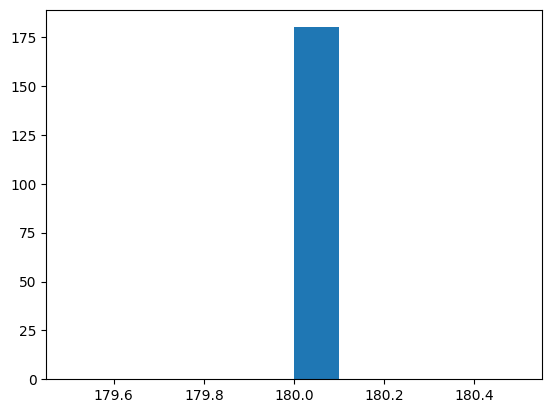

In [16]:
plt.hist(data.Duration)
plt.show()

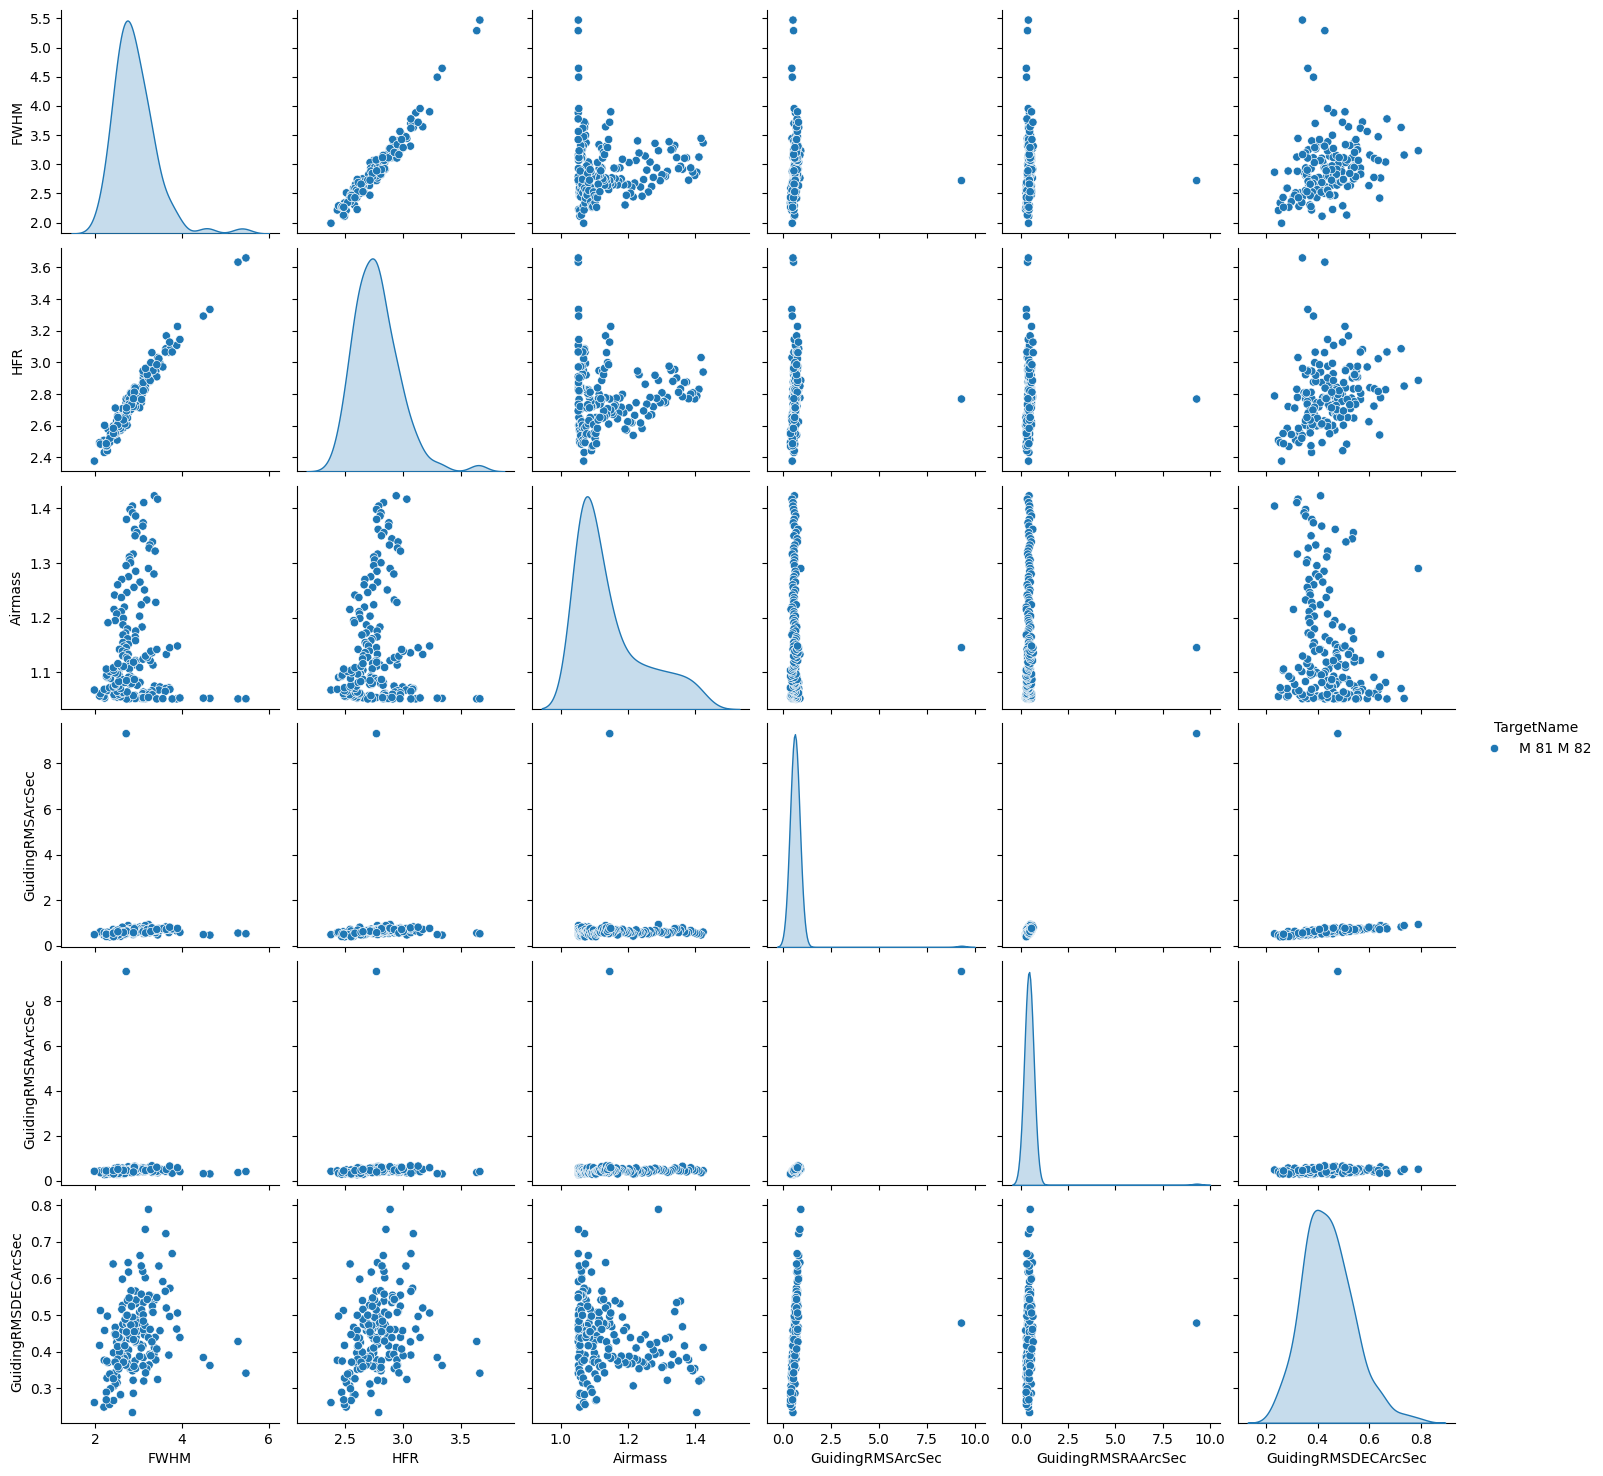

In [17]:
import seaborn as sns

sns.pairplot(data.filter(['FWHM', 'HFR', 'Airmass', 'GuidingRMSArcSec', 'GuidingRMSRAArcSec', 'GuidingRMSDECArcSec', 'TargetName']), hue='TargetName')
plt.show()

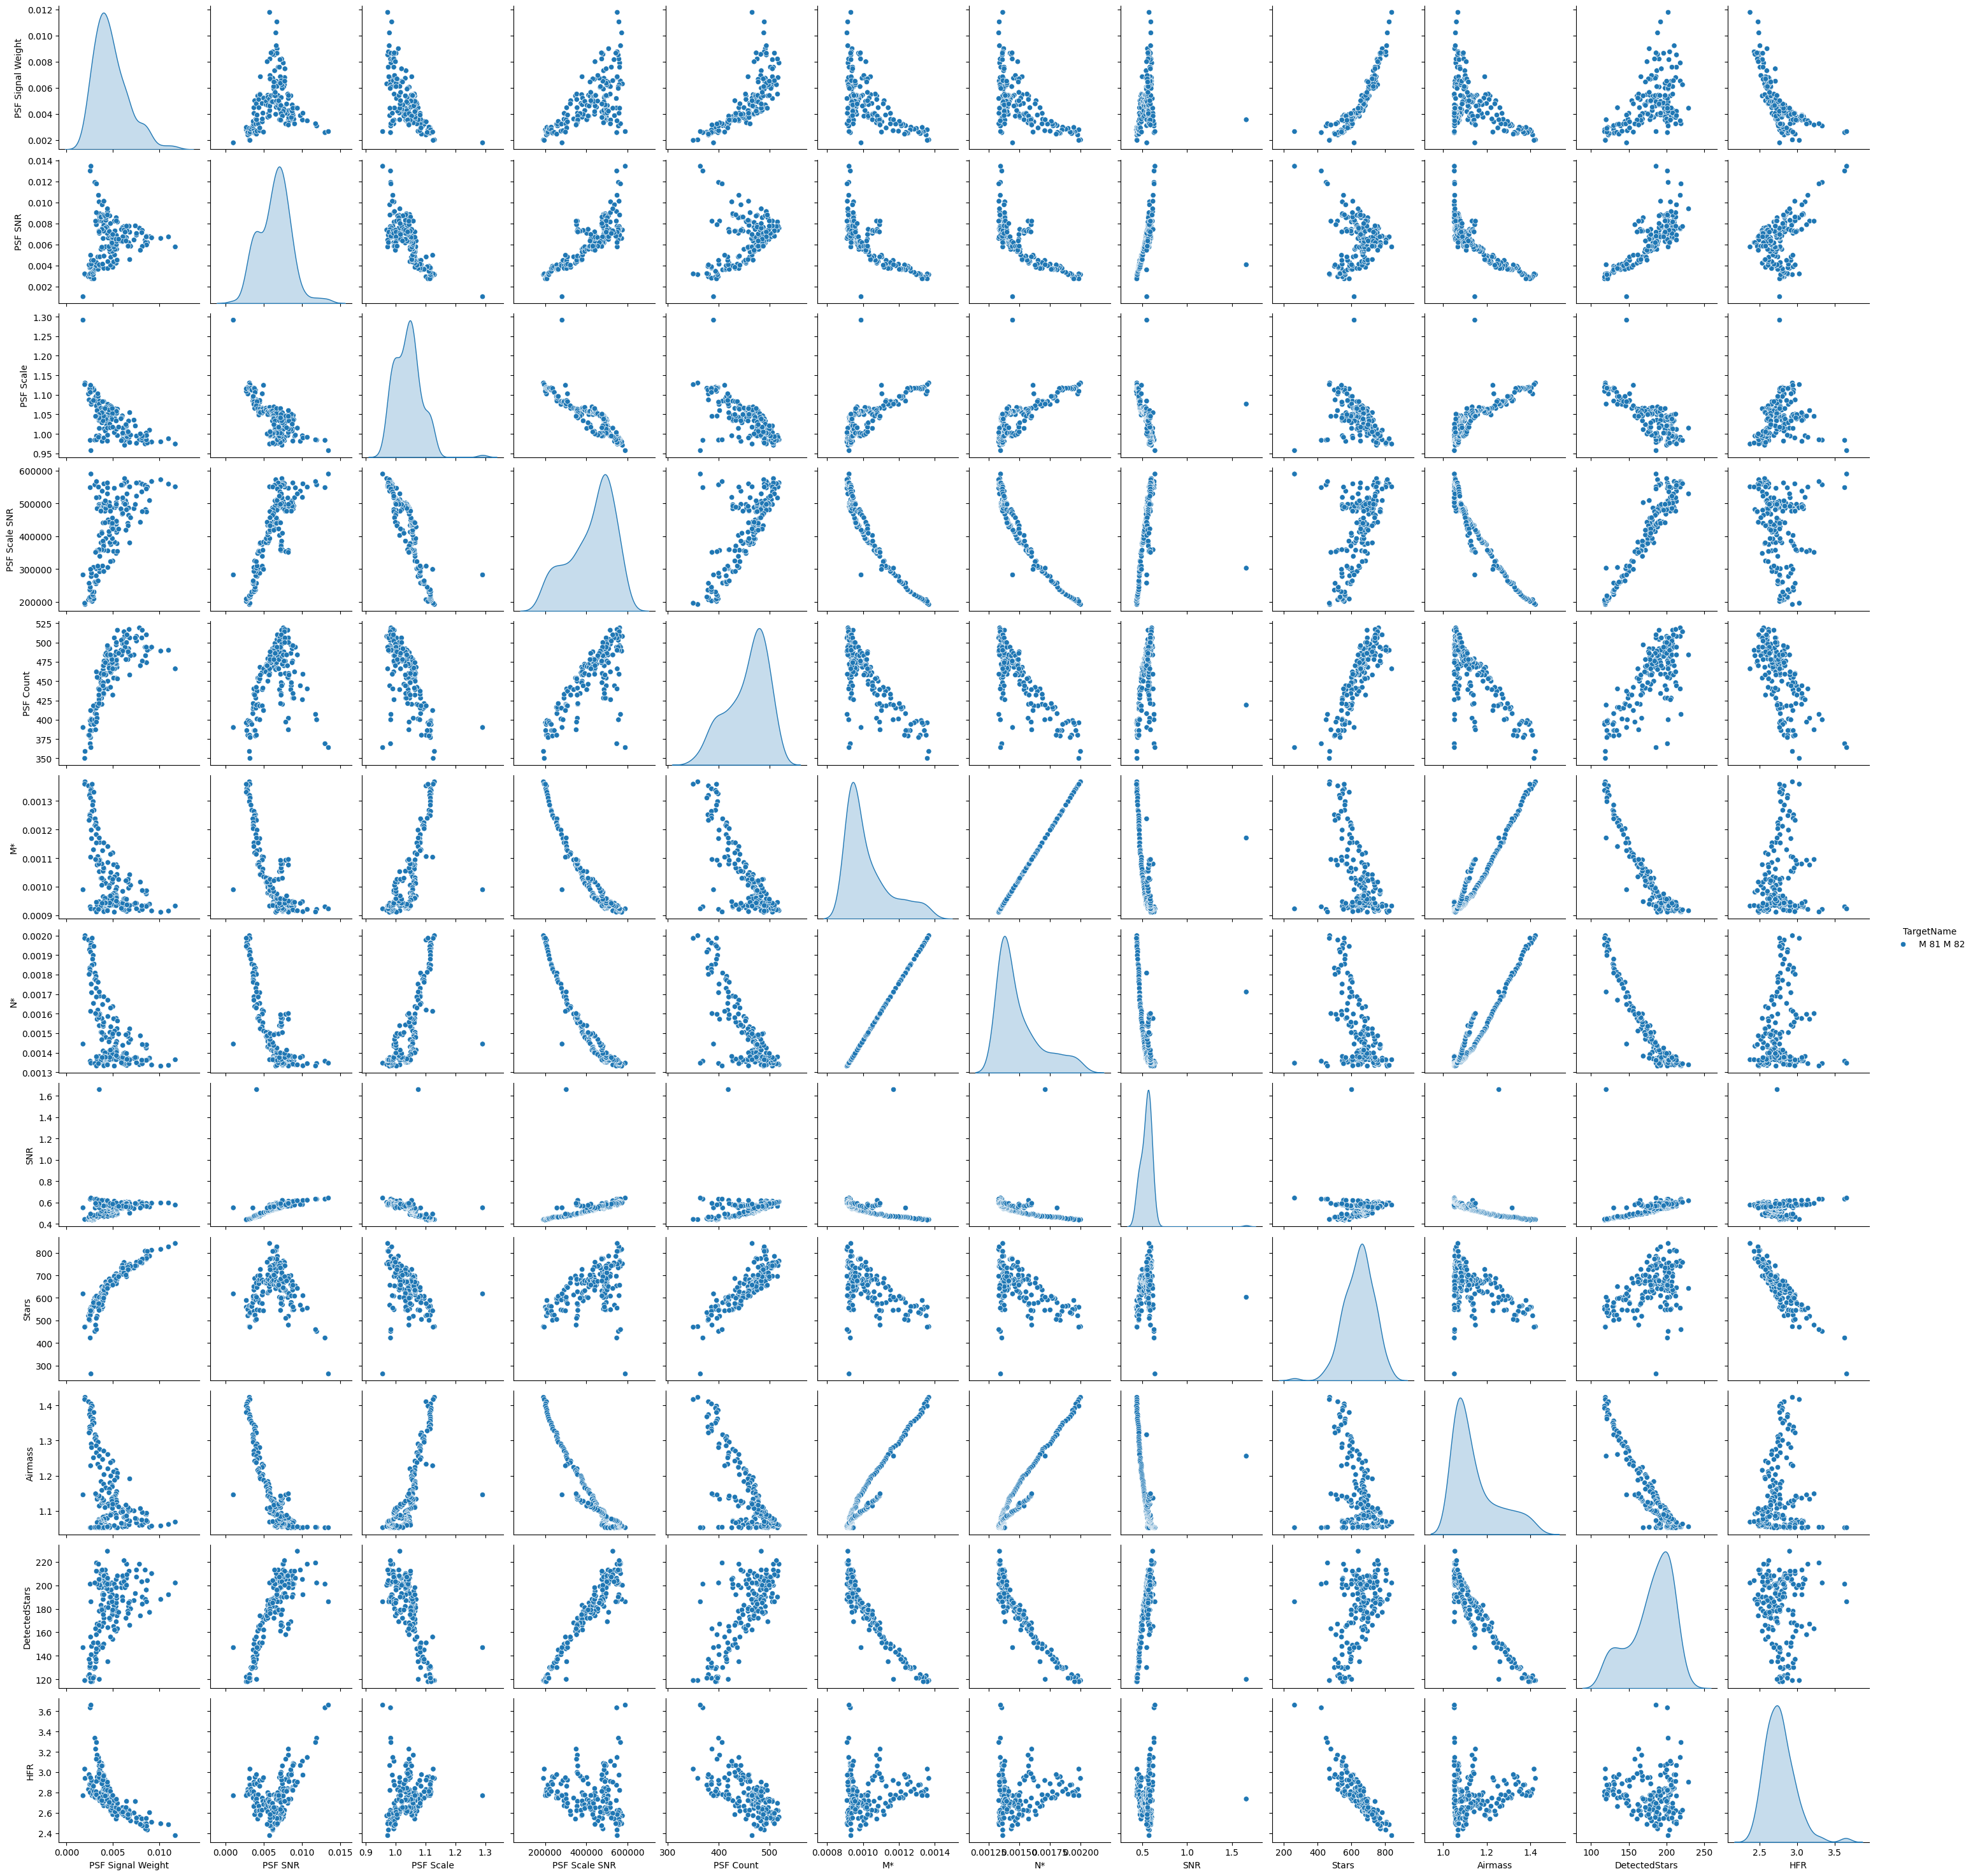

In [18]:
import seaborn as sns

sns.pairplot(data.filter(['PSF Signal Weight', 'PSF SNR', 'PSF Scale', 'PSF Scale SNR', 'PSF Count', 'PSF', 'M*', 'N*', 'SNR', 'Stars', 'Airmass', 'DetectedStars', 'HFR', 'TargetName']), hue='TargetName')
plt.show()

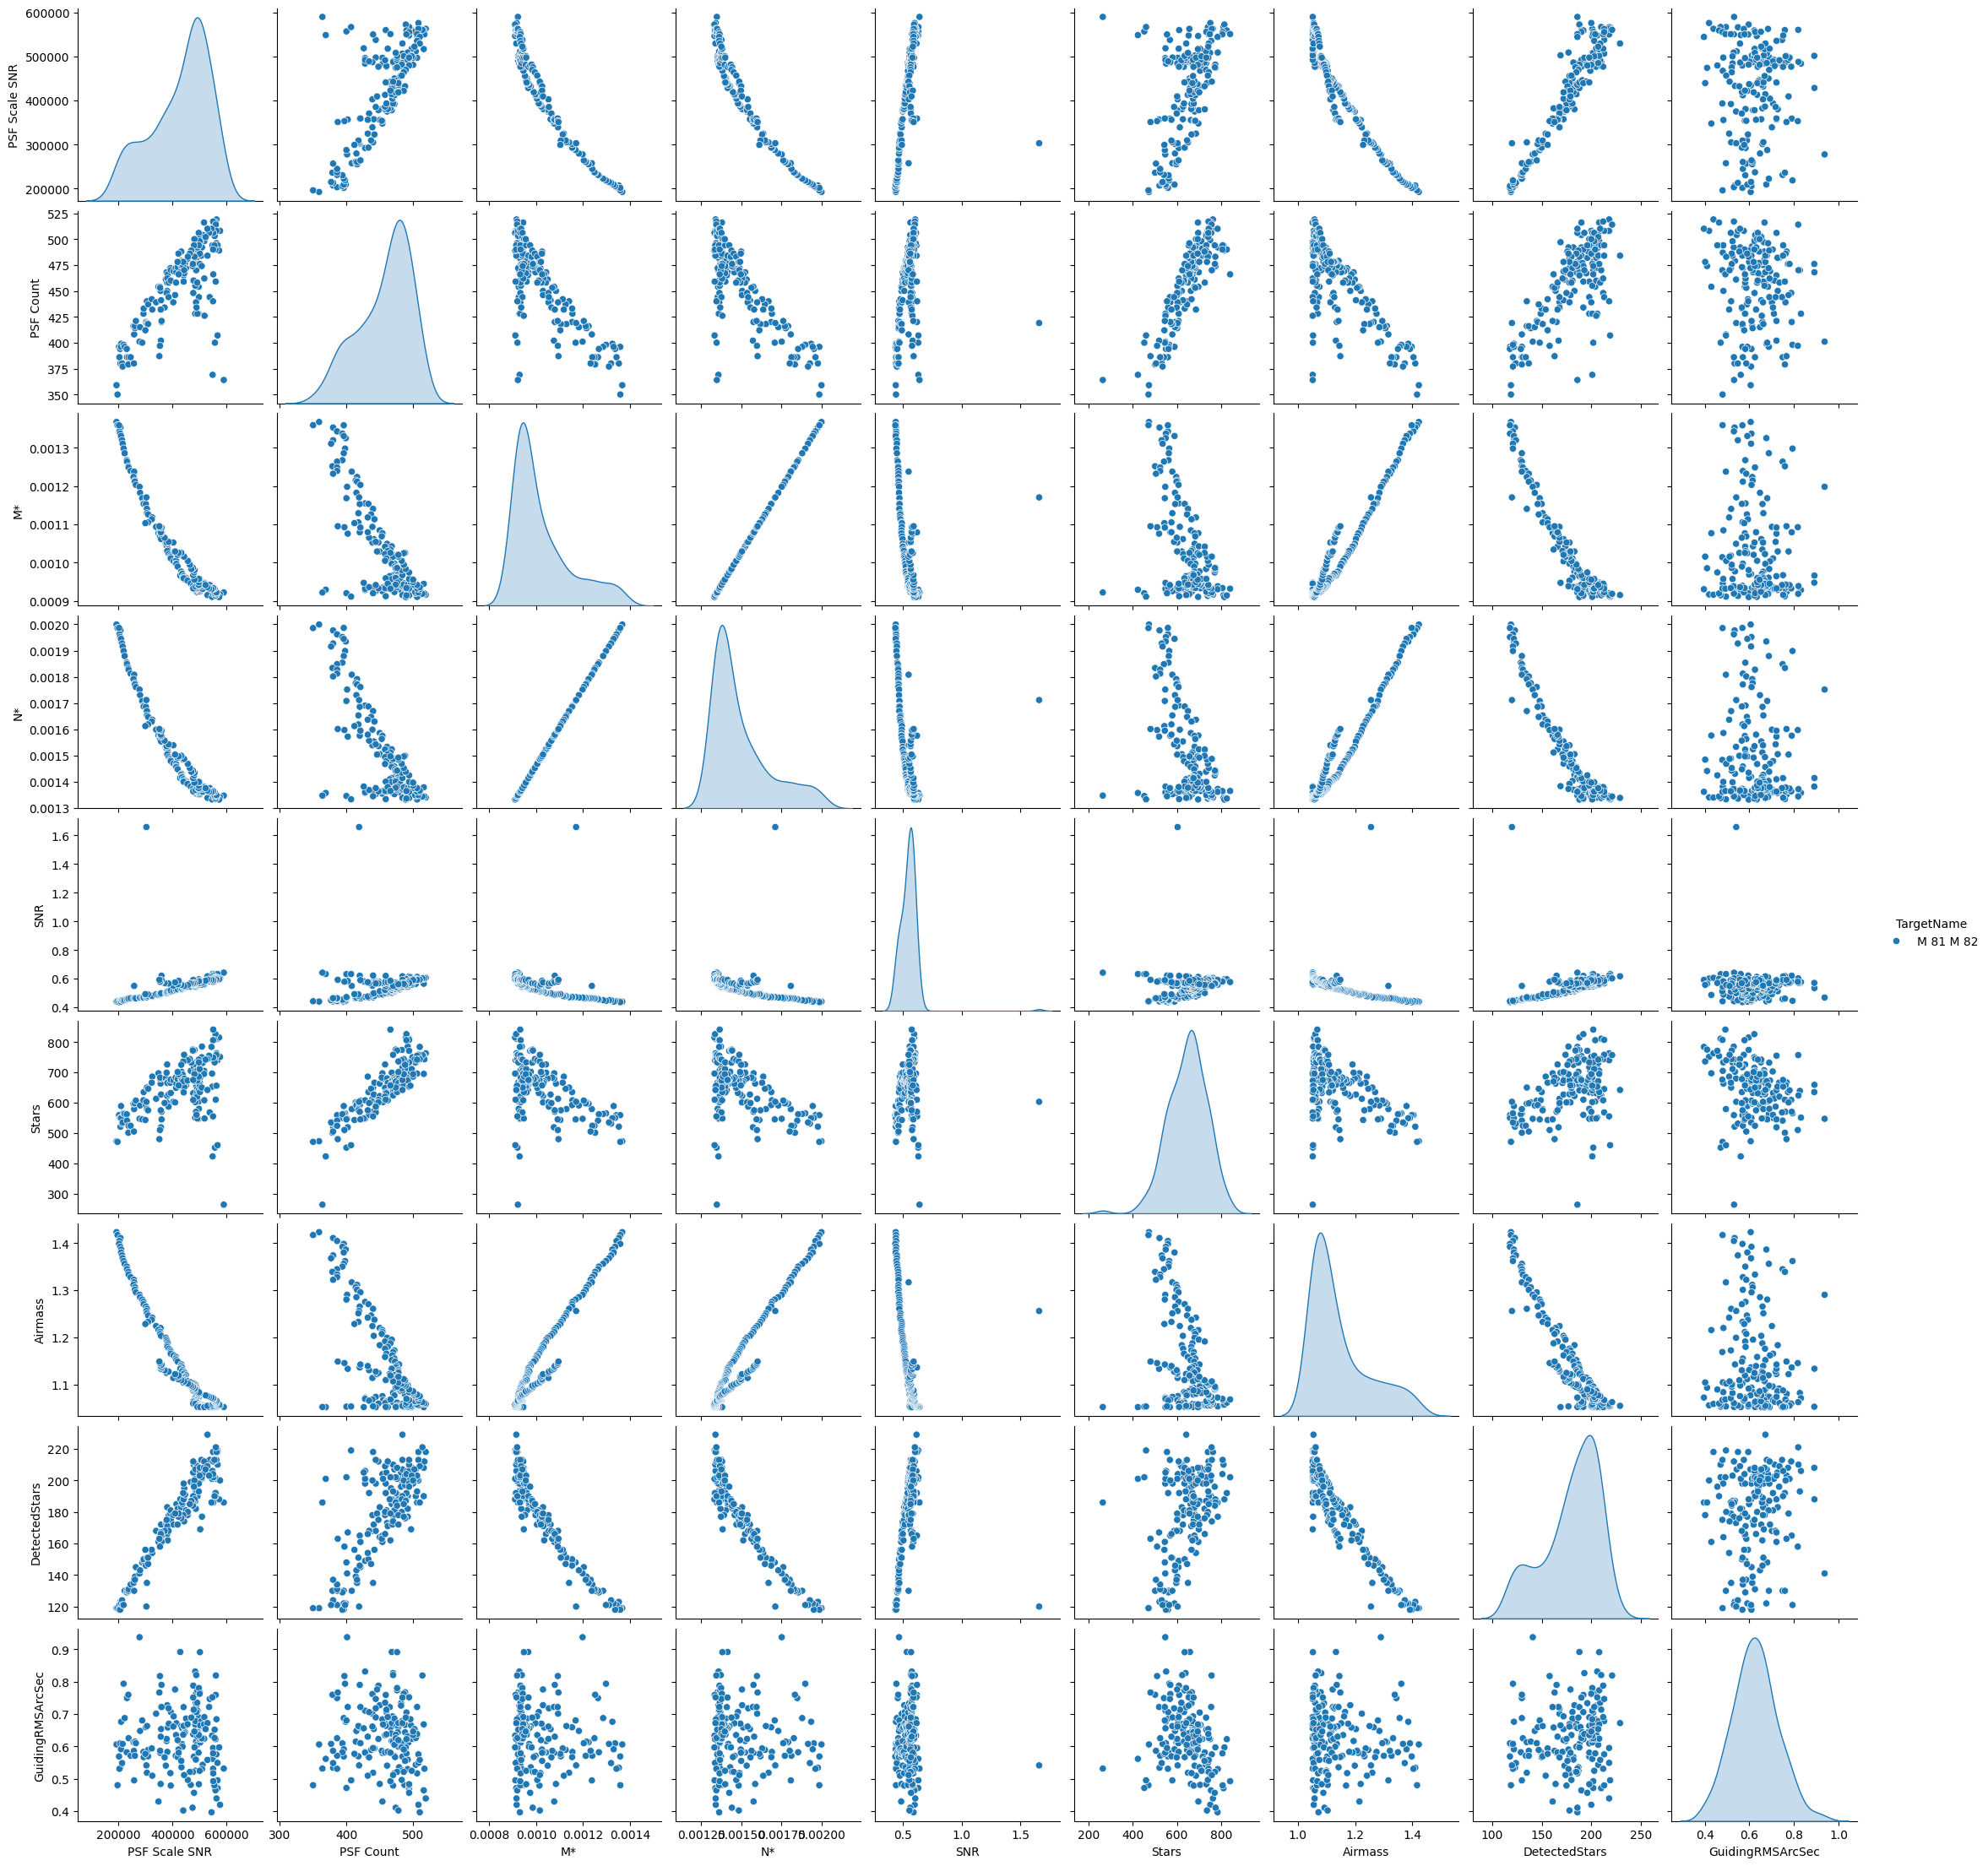

In [19]:
import seaborn as sns

sns.pairplot(data.filter(['PSF Scale SNR', 'PSF Count', 'PSF', 'M*', 'N*', 'SNR', 'Stars', 'Airmass', 'DetectedStars', 'GuidingRMSArcSec', 'TargetName']).query('GuidingRMSArcSec < 6'), hue='TargetName')
plt.show()

## Conclusion

There's no relationship / correclation between PSF measure and Guiding RMS

# HFR & FHWM

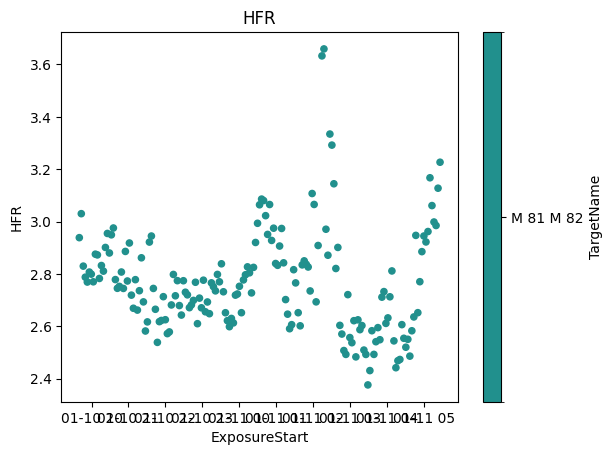

In [20]:
data.plot.scatter(x='ExposureStart', y='HFR', c='TargetName', colormap='viridis', title="HFR")
plt.show()

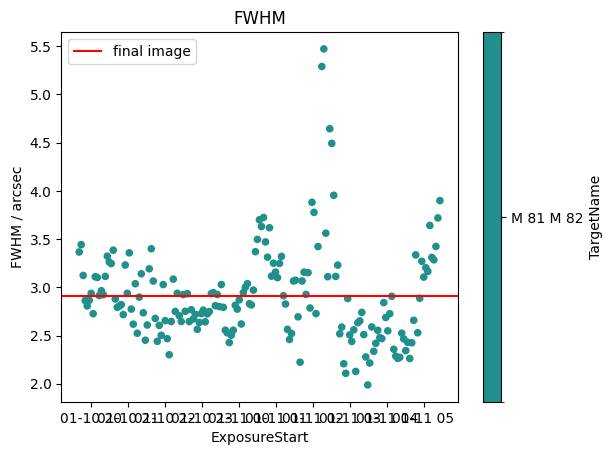

In [21]:
data.plot.scatter(x='ExposureStart', y='FWHM', c='TargetName', colormap='viridis', title="FWHM")
plt.axhline(final_FWHM, color='r', linestyle='-', label="final image")
plt.ylabel("FWHM / arcsec")
plt.legend()
plt.savefig("FWHM_vs_ExposureStart.png", transparent=True)
plt.show()

In [22]:
data.FWHM.describe()

count    180.000000
mean       2.915533
std        0.499895
min        1.987900
25%        2.588700
50%        2.823600
75%        3.127125
max        5.471800
Name: FWHM, dtype: float64

In [23]:
final_FWHM

2.9074999999999998

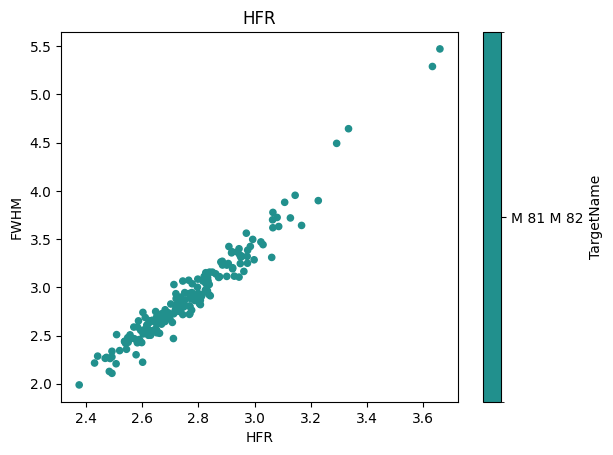

In [24]:
data.plot.scatter(x='HFR', y='FWHM', c='TargetName', colormap='viridis', title="HFR")
plt.show()

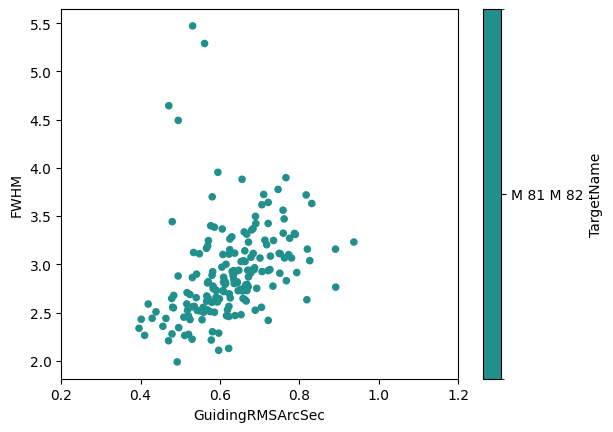

In [25]:
data.plot.scatter(x='GuidingRMSArcSec', y='FWHM', c='TargetName', colormap='viridis')
plt.xlim(0.2,1.2) # Excluding an outlier
plt.show()

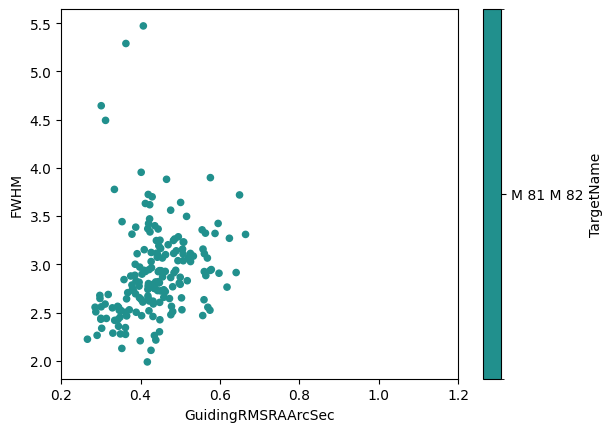

In [26]:
data.plot.scatter(x='GuidingRMSRAArcSec', y='FWHM', c='TargetName', colormap='viridis')
plt.xlim(0.2,1.2) # Excluding an outlier
plt.show()

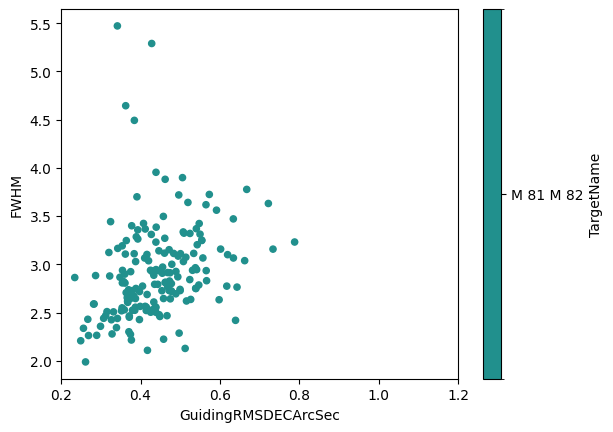

In [27]:
data.plot.scatter(x='GuidingRMSDECArcSec', y='FWHM', c='TargetName', colormap='viridis')
plt.xlim(0.2,1.2) # Excluding an outlier
plt.show()

## Conclusion

FWHM and therefore HFR depend on Guiding RMS. It's quite noisy though. Needs and will be modelled in Robust Linear Regression section.

# PSF measures

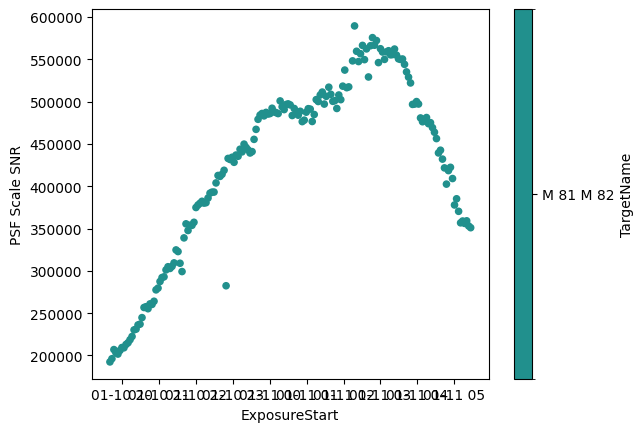

In [28]:
data.plot.scatter(x='ExposureStart', y='PSF Scale SNR', c='TargetName', colormap='viridis') 
plt.show()

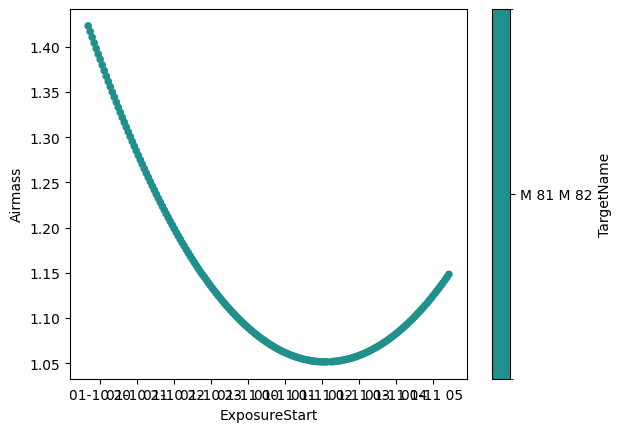

In [29]:
data.plot.scatter(x='ExposureStart', y='Airmass', c='TargetName', colormap='viridis') 
plt.show()

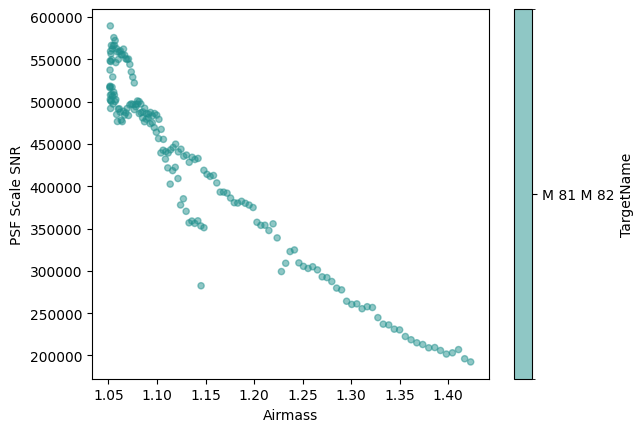

In [30]:
data.plot.scatter(x='Airmass', y='PSF Scale SNR', c='TargetName', colormap='viridis', alpha=0.5)
plt.show()

# Guiding RMS Values

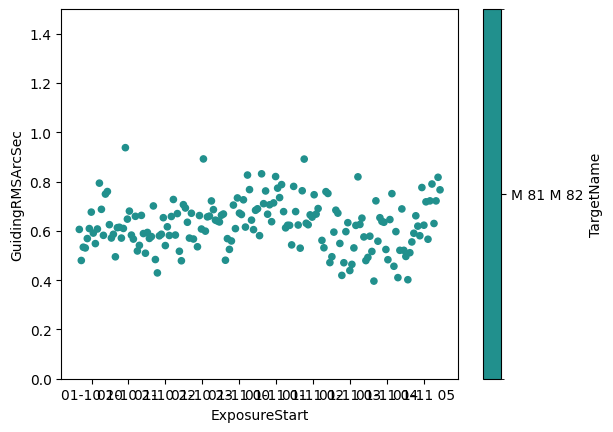

In [31]:
data.plot.scatter(x='ExposureStart', y='GuidingRMSArcSec', c='TargetName', colormap='viridis') 
plt.ylim(0,1.5) # Eclude one outlier (> 8)
plt.show()

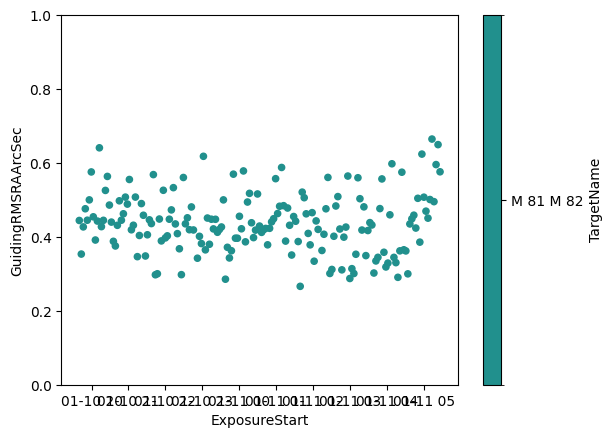

In [32]:
data.plot.scatter(x='ExposureStart', y='GuidingRMSRAArcSec', c='TargetName', colormap='viridis') 
plt.ylim(0,1)
plt.show()

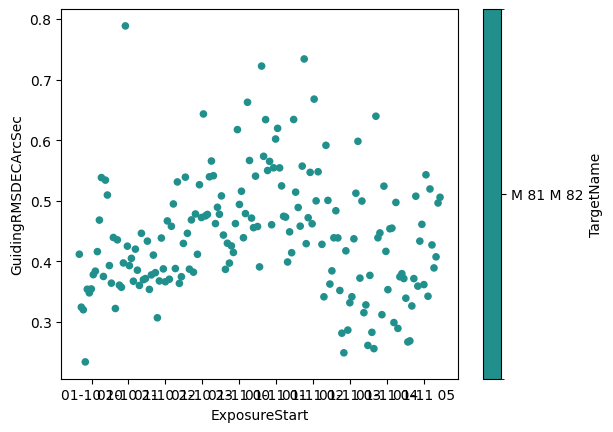

In [33]:
data.plot.scatter(x='ExposureStart', y='GuidingRMSDECArcSec', c='TargetName', colormap='viridis') 
plt.show()

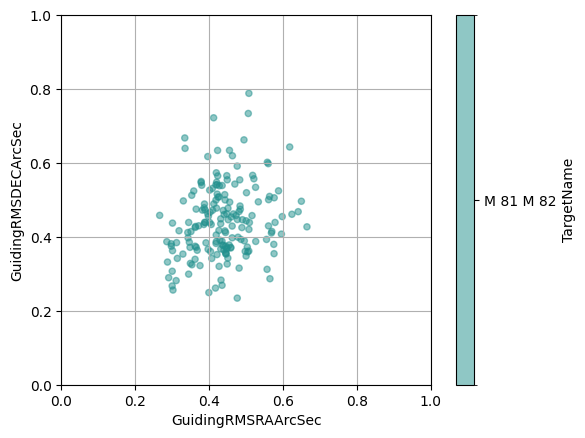

In [34]:
data.plot.scatter(x='GuidingRMSRAArcSec', y='GuidingRMSDECArcSec', c='TargetName', colormap='viridis', alpha=0.5)
plt.gca().set_aspect('equal')
plt.xlim(0,1)
plt.ylim(0,1)
plt.grid(True)
plt.savefig("RMS_RA_vs_DEC.png", transparent=True)
plt.show()

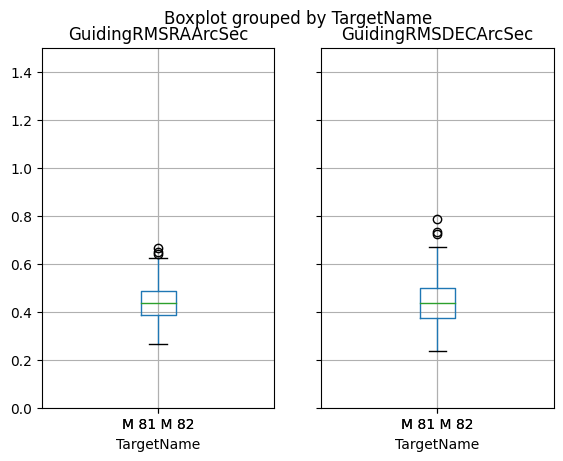

In [35]:
data.boxplot(column=['GuidingRMSRAArcSec', 'GuidingRMSDECArcSec'], by='TargetName' )
plt.ylim(0,1.5)
plt.show()

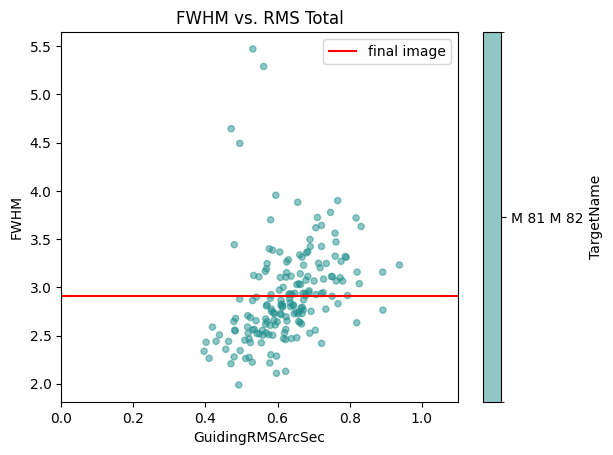

In [36]:
data.plot.scatter(x='GuidingRMSArcSec', y='FWHM', c='TargetName', colormap='viridis', title="FWHM vs. RMS Total", alpha=0.5)
plt.xlim(0,1.1)
plt.axhline(final_FWHM, color='r', linestyle='-', label="final image")
plt.legend()
plt.savefig("FWHM_vs_RMS.png", transparent=True)
plt.show()

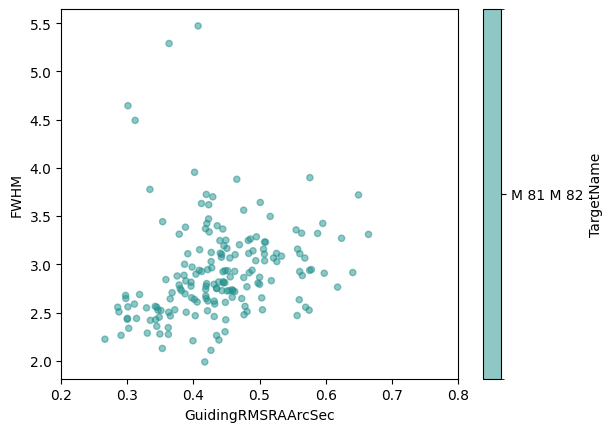

In [37]:
data.plot.scatter(x='GuidingRMSRAArcSec', y='FWHM', c='TargetName', colormap='viridis', alpha=0.5)
plt.xlim(0.2,0.8)
plt.show()

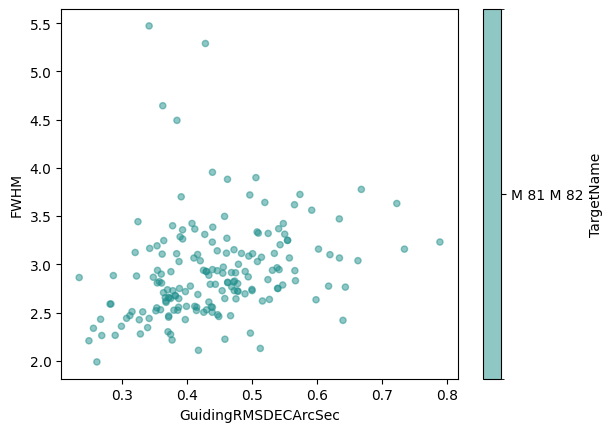

In [13]:
import matplotlib.pyplot as plt 

data.plot.scatter(x='GuidingRMSDECArcSec', y='FWHM', c='TargetName', colormap='viridis', alpha=0.5)
#plt.xlim(0,1.5)
plt.show()

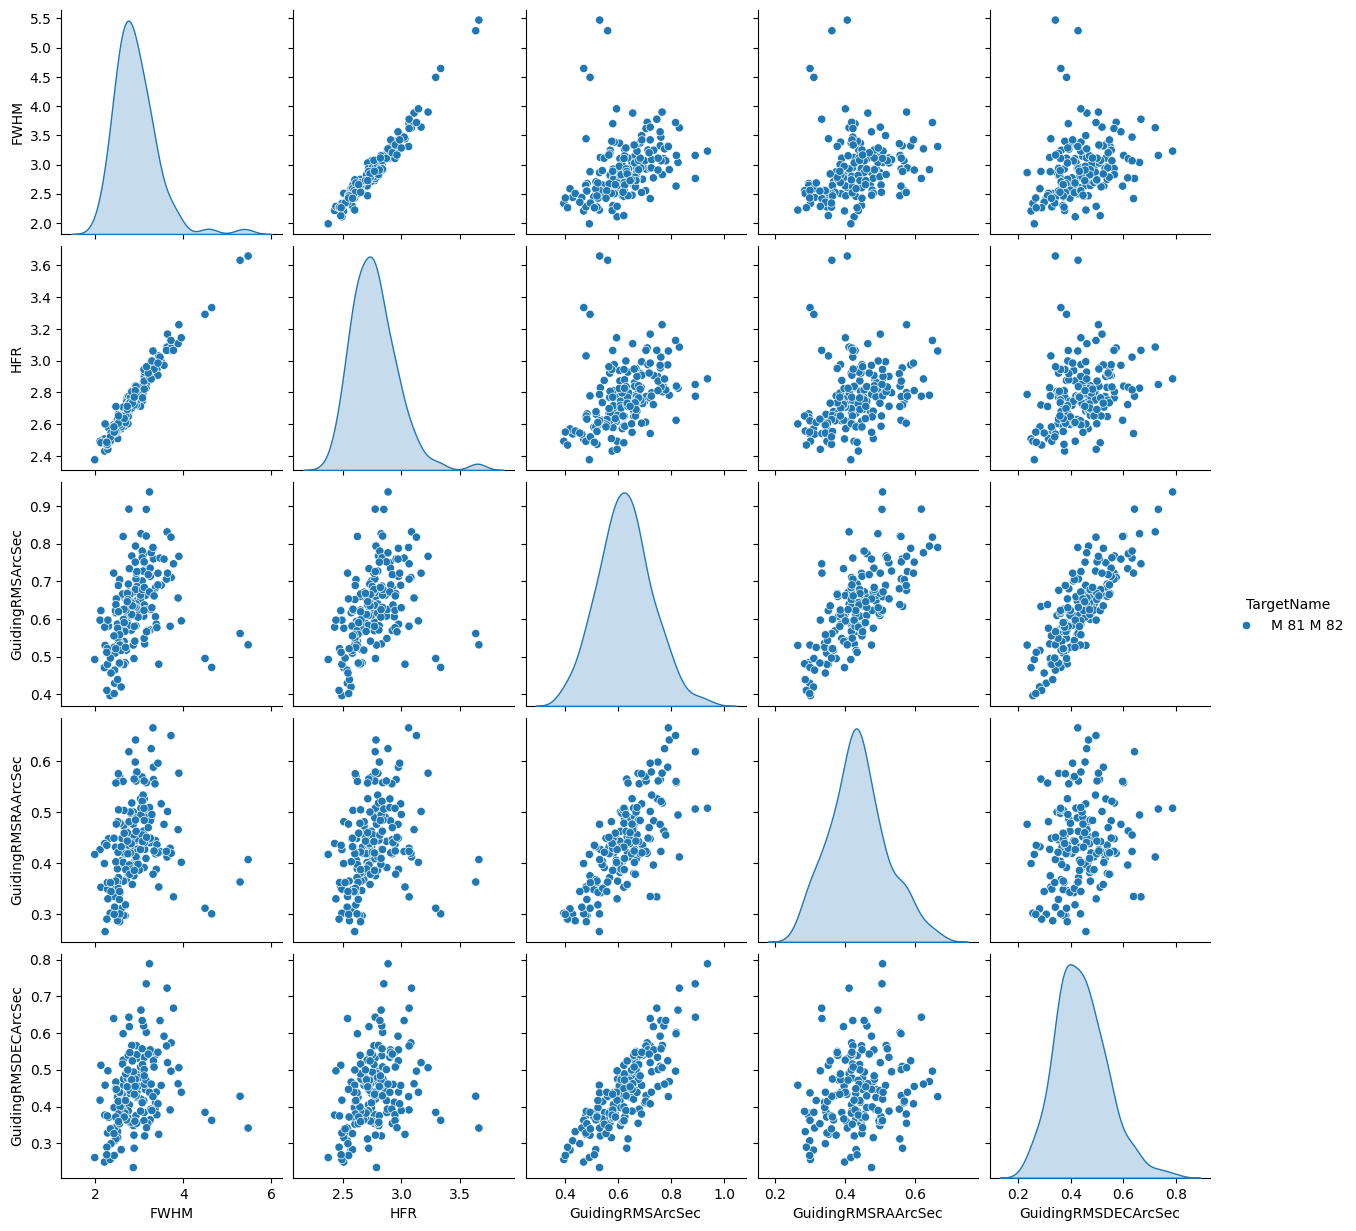

In [39]:
import seaborn as sns

sns.pairplot(data.filter(['FWHM', 'HFR', 'GuidingRMSArcSec', 'GuidingRMSRAArcSec', 'GuidingRMSDECArcSec', 'TargetName']).query('GuidingRMSArcSec < 8'), hue='TargetName')
plt.savefig("Lattice_FWHM_vs_RMS.png", transparent=True)
plt.show()

## Linear Regression FWHM vs. RMS

In [14]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

linreg = smf.ols("FWHM ~ HFR", data.query("FWHM < 4.2").query("GuidingRMSArcSec < 8")).fit()
linreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   FWHM   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     2512.
Date:                Mon, 18 Mar 2024   Prob (F-statistic):          6.03e-105
Time:                        08:17:47   Log-Likelihood:                 156.22
No. Observations:                 175   AIC:                            -308.4
Df Residuals:                     173   BIC:                            -302.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.3708      0.125    -27.025      0.000      -3.617      -3.125
HFR            2.2661      0.045     50.123      0.000       2.177       2.355
==============================================================================
Omnibus:                        2.295   Durbin-Watson:                   1.673
Prob(Omnibus):                  0.317   Jarque-Bera (JB):                1.932
Skew:                          -0.153   Prob(JB):                        0.381
Kurtosis:                       3.414   Cond. No.                         51.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

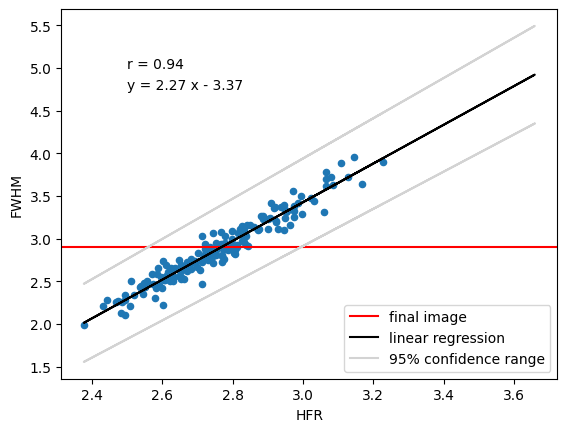

In [25]:
data.query("FWHM < 4.2").query("GuidingRMSArcSec < 8").plot.scatter("HFR", "FWHM")
plt.axhline(final_FWHM, color='r', linestyle='-', label="final image")
plt.plot(data.HFR, linreg.predict(data.HFR), color="black", label="linear regression")
plt.plot(data.HFR, data.HFR*(2.177)-3.617, color="lightgray", label="95% confidence range")
plt.plot(data.HFR, data.HFR*(2.355)-3.125, color="lightgray")
plt.text(2.5,5, "r = 0.94")
plt.text(2.5,4.75, "y = 2.27 x - 3.37")
plt.legend(loc="lower right")
plt.savefig("linregFWHMvsHFR.png", transparent=True)
plt.show()

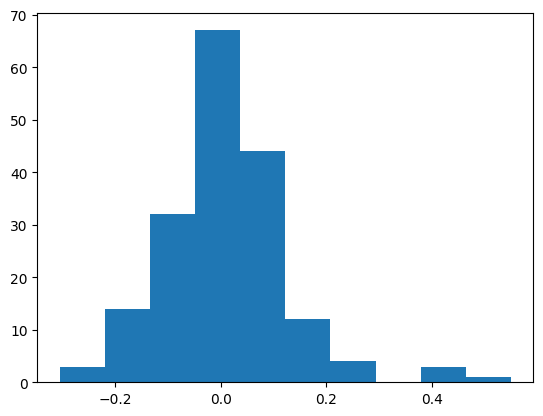

In [69]:
resid = data.FWHM - linreg.predict(data.HFR)
plt.hist(resid)
plt.show()

In [33]:
linreg = smf.ols("FWHM ~ GuidingRMSArcSec", data.query("FWHM < 4.2").query("GuidingRMSArcSec < 8")).fit()
linreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   FWHM   R-squared:                       0.300
Model:                            OLS   Adj. R-squared:                  0.296
Method:                 Least Squares   F-statistic:                     74.13
Date:                Mon, 18 Mar 2024   Prob (F-statistic):           4.38e-15
Time:                        09:57:33   Log-Likelihood:                -52.523
No. Observations:                 175   AIC:                             109.0
Df Residuals:                     173   BIC:                             115.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.5210      0.159      9.591      0.000       1.208       1.834
GuidingRMSArcSec     2.1440      0.249      8.610      0.000       1.653       2.636
==============================================================================
Omnibus:                       15.895   Durbin-Watson:                   0.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               18.311
Skew:                           0.654   Prob(JB):                     0.000106
Kurtosis:                       3.895   Cond. No.                         14.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

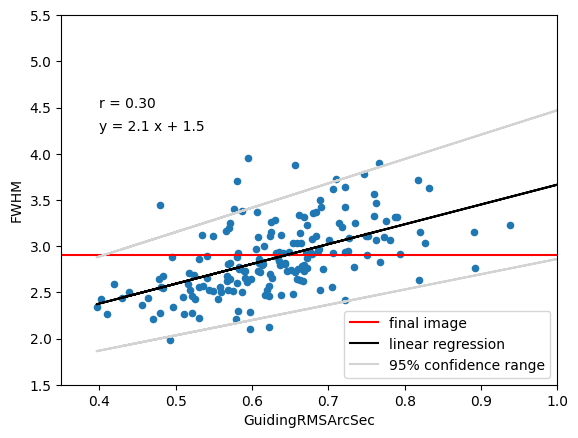

In [36]:
data.query("FWHM < 4.2").query("GuidingRMSArcSec < 8").plot.scatter("GuidingRMSArcSec", "FWHM")
plt.axhline(final_FWHM, color='r', linestyle='-', label="final image")
plt.plot(data.GuidingRMSArcSec, linreg.predict(data.GuidingRMSArcSec), color="black", label="linear regression")
plt.plot(data.GuidingRMSArcSec, data.GuidingRMSArcSec*(1.653)+1.208, color="lightgray", label="95% confidence range")
plt.plot(data.GuidingRMSArcSec, data.GuidingRMSArcSec*(2.636)+1.834, color="lightgray")
plt.xlim(0.35,1.)
plt.ylim(1.5,5.5)
plt.text(0.4,4.5, "r = 0.30")
plt.text(0.4,4.25, "y = 2.1 x + 1.5")
plt.legend(loc="lower right")
plt.savefig("linregFWHMvsRMS.png", transparent=True)
plt.show()

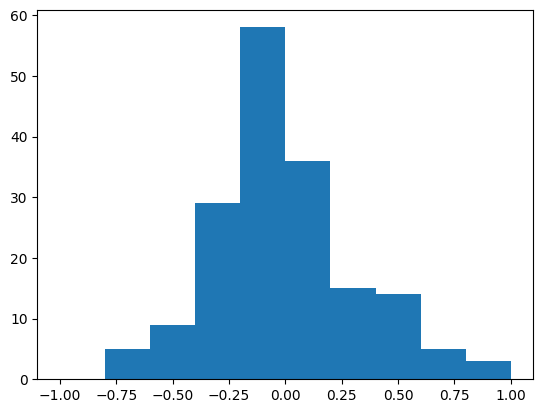

In [35]:
resid = data.FWHM - linreg.predict(data.GuidingRMSArcSec)
plt.hist(resid, range=(-1,1))
plt.show()

In [30]:
linreg = smf.ols("FWHM ~ GuidingRMSRAArcSec + GuidingRMSDECArcSec", data.query("FWHM < 4.2").query("GuidingRMSArcSec < 8")).fit()
linreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   FWHM   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.296
Method:                 Least Squares   F-statistic:                     37.65
Date:                Mon, 18 Mar 2024   Prob (F-statistic):           2.75e-14
Time:                        08:41:19   Log-Likelihood:                -51.958
No. Observations:                 175   AIC:                             109.9
Df Residuals:                     172   BIC:                             119.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               1.4878      0.163      9.115      0.000       1.166       1.810
GuidingRMSRAArcSec      1.6520      0.316      5.221      0.000       1.027       2.277
GuidingRMSDECArcSec     1.4797      0.257      5.747      0.000       0.972       1.988
==============================================================================
Omnibus:                       16.620   Durbin-Watson:                   0.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               19.248
Skew:                           0.677   Prob(JB):                     6.61e-05
Kurtosis:                       3.899   Cond. No.                         16.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Eccentricity

The Eccentricity is given as

$$ \text{Ecc} = \sqrt{ 1 - \frac{a^2}{b^2}}$$

with ellipse axes $a$ and $b$ with $ a < b $. So we can plot it for $a/b \in [0.5,1]$:



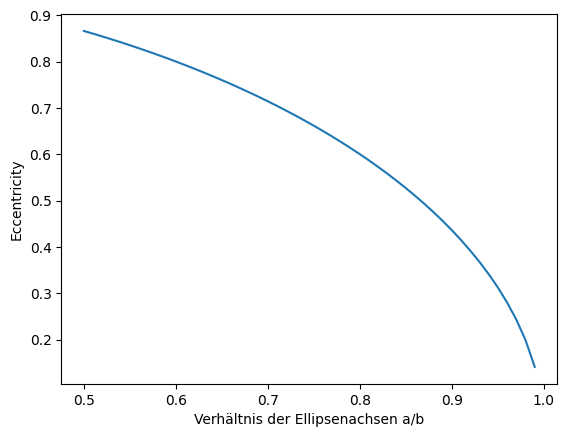

In [47]:
import numpy as np
import math

ab = np.arange(0.5,1.,0.01)
plt.plot(ab, np.sqrt(1-ab*ab))
plt.ylabel("Eccentricity")
plt.xlabel("Verhältnis der Ellipsenachsen a/b")
plt.show()

Solving that equation for $a/b$, it is
$$ a/b = \sqrt{1-\text{Ecc}^2} $$

Let's have a look how our pictures are distributed on this graph:

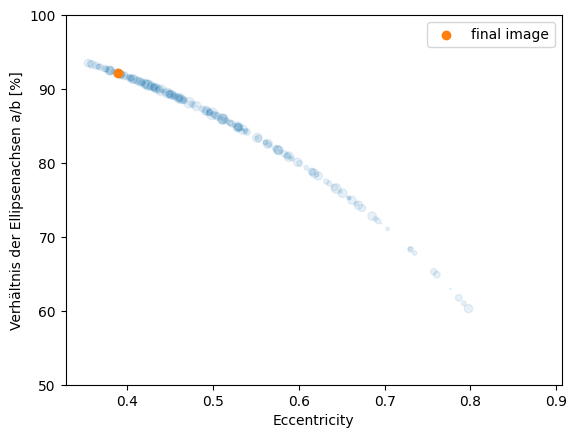

In [56]:
import math 

plt.scatter(data.Eccentricity, 100. * np.sqrt(1-data.Eccentricity * data.Eccentricity), s=(data.HFR -3.2)*(data.HFR - 3.2)*100, alpha=0.1)
plt.xlabel("Eccentricity")
plt.ylabel("Verhältnis der Ellipsenachsen a/b [%]")
plt.scatter(final_Eccentricity, 100. * math.sqrt(1-final_Eccentricity * final_Eccentricity), label="final image")
plt.ylim(50.,100.)
plt.legend()
plt.savefig("EllipsenachsenEccentricity.png", transparent=True)
plt.show()

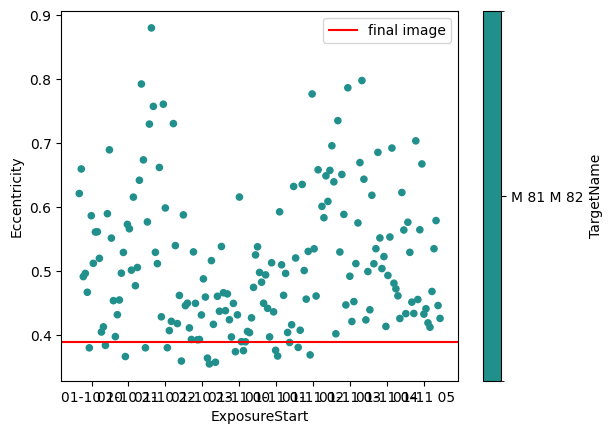

In [58]:
data.plot.scatter(x='ExposureStart', y='Eccentricity', c='TargetName', colormap='viridis') 
plt.axhline(final_Eccentricity, color='r', linestyle='-', label="final image")
plt.legend()
plt.savefig("Eccentricity_vs_ExposureStart_M82M81.png", transparent=True)
plt.show()

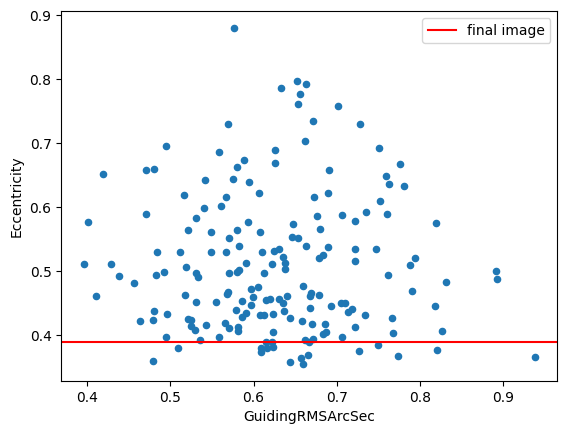

In [38]:
data.query('GuidingRMSArcSec < 8').plot.scatter(x='GuidingRMSArcSec', y='Eccentricity')
plt.axhline(final_Eccentricity, color='r', linestyle='-', label="final image")
plt.legend()
plt.show()

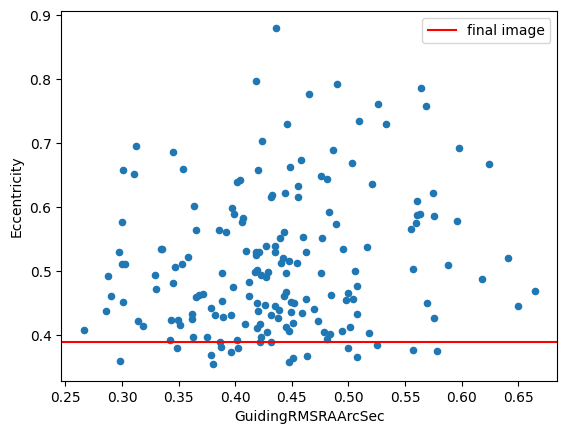

In [39]:
data.query('GuidingRMSArcSec < 8').plot.scatter(x='GuidingRMSRAArcSec', y='Eccentricity')
plt.axhline(final_Eccentricity, color='r', linestyle='-', label="final image")
plt.legend()
plt.show()

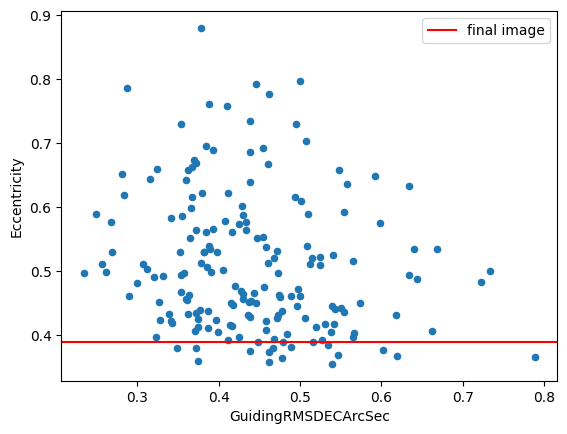

In [40]:
data.query('GuidingRMSArcSec < 8').plot.scatter(x='GuidingRMSDECArcSec', y='Eccentricity')
plt.axhline(final_Eccentricity, color='r', linestyle='-', label="final image")
plt.legend()
plt.show()

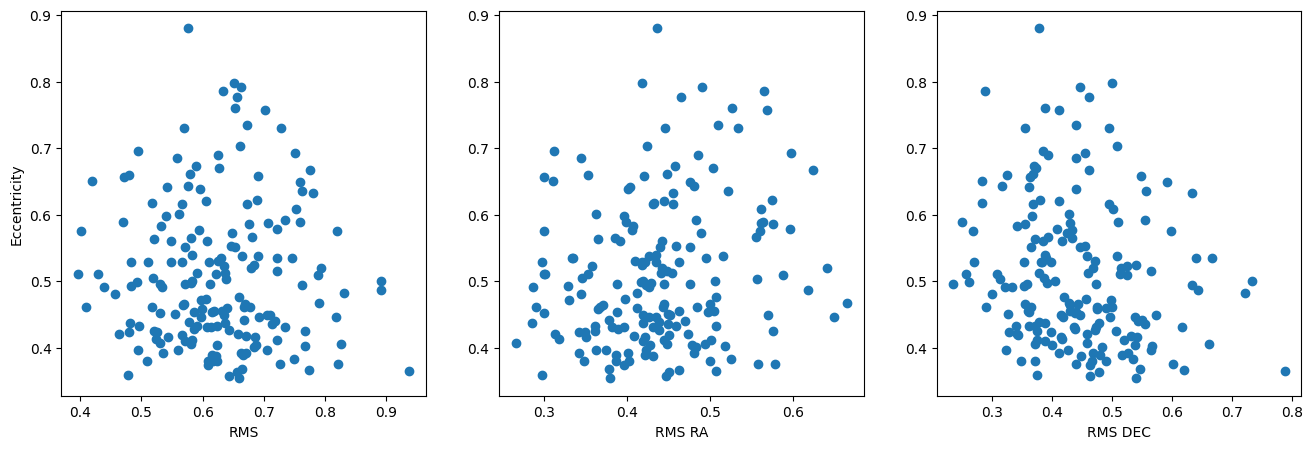

In [56]:
#sns.pairplot(data.filter(['Eccentricity', 'GuidingRMSArcSec', 'GuidingRMSRAArcSec', 'GuidingRMSDECArcSec', 'TargetName']).query('GuidingRMSArcSec < 8'), hue='TargetName')
#plt.savefig("Lattice_Ecc_vs_RMS.png", transparent=True)
#plt.show()

plt.figure(figsize=(16,5))
plt.subplot(131)
plt.scatter(data.query('GuidingRMSArcSec < 8').GuidingRMSArcSec, data.query('GuidingRMSArcSec < 8').Eccentricity)
plt.xlabel("RMS")
plt.ylabel("Eccentricity")
plt.subplot(132)
plt.scatter(data.query('GuidingRMSArcSec < 8').GuidingRMSRAArcSec, data.query('GuidingRMSArcSec < 8').Eccentricity)
plt.xlabel("RMS RA")
plt.subplot(133)
plt.scatter(data.query('GuidingRMSArcSec < 8').GuidingRMSDECArcSec, data.query('GuidingRMSArcSec < 8').Eccentricity)
plt.xlabel("RMS DEC")
plt.savefig("Lattice_Ecc_vs_RMS.png")
plt.show()